In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


## Котировки

In [2]:
df = pd.read_csv('Data/TQBR.SBER_4H1.txt', sep='\t')

In [3]:
def func_1(x):
    
    return datetime.strptime(x[:10], '%d.%m.%Y')

df.datetime = df.datetime.apply(lambda x: func_1(x))
df.datetime = df.datetime.astype('datetime64')

C:\Users\yaroslav\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


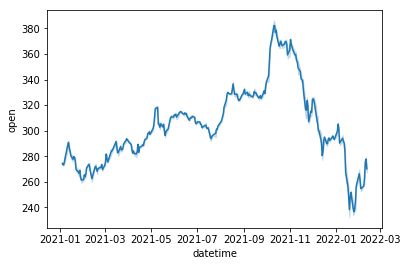

In [4]:
sns.lineplot(data=df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')], x="datetime", y="open")

In [5]:
df = df.loc[lambda x: x.datetime >= pd.to_datetime('2021-01-01')].set_index('datetime')
df.head()

,open,high,low,close,volume
datetime,,,,,
2021-01-04,274.67,274.67,272.54,273.95,1051383
2021-01-04,273.95,276.28,273.93,275.06,1499956
2021-01-04,274.96,276.60,273.77,273.80,1674926
2021-01-04,273.83,273.90,270.61,272.00,653681
2021-01-05,272.67,273.28,270.28,272.38,1255856


## Индикатор

In [6]:
# STOCHASTIC OSCILLATOR CALCULATION

def get_stoch_osc(high, low, close, k_lookback, d_lookback):
    lowest_low = low.rolling(k_lookback).min()
    highest_high = high.rolling(k_lookback).max()
    k_line = ((close - lowest_low) / (highest_high - lowest_low)) * 100
    d_line = k_line.rolling(d_lookback).mean()
    return k_line, d_line

df['%k'], df['%d'] = get_stoch_osc(df['high'], df['low'], df['close'], 14, 3)
df.tail()

,open,high,low,close,volume,%k,%d
datetime,,,,,,,
2022-02-11,274.90,275.87,272.61,273.53,810792,57.323601,73.311076
2022-02-11,273.53,274.68,266.58,267.76,5956437,20.935291,50.124004
2022-02-11,267.76,269.80,264.99,267.83,6584398,16.406701,31.555198
2022-02-11,267.83,269.40,265.55,266.56,3506597,9.069902,15.470631
2022-02-11,266.56,266.61,266.01,266.58,104126,9.185442,11.554015


## TRADING STRATEGY

In [27]:
# TRADING STRATEGY

def stoch_signals(prices, k, d):    
    buy_price = []
    sell_price = []
    stoch_signal = []
    signal = 0

    for i in range(len(prices)):
        if k[i] < 20 and d[i] < 20 and k[i] < d[i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        elif k[i] > 80 and d[i] > 80 and k[i] > d[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                stoch_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                stoch_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            stoch_signal.append(0)
            
    return buy_price, sell_price, stoch_signal


In [8]:
buy_price, sell_price, stoch_signal = stoch_signals(df['close'], df['%k'], df['%d'])

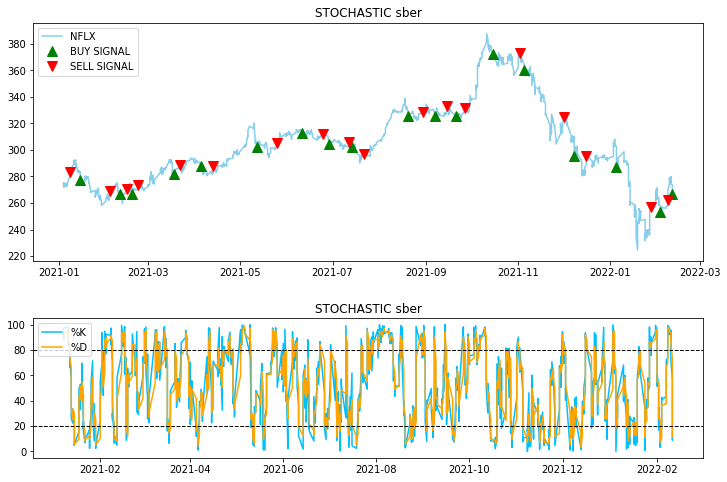

In [18]:
#4H
prod_name = 'sber'
signals_plot(df, buy_price, sell_price, prod_name)

In [17]:
def signals_plot(df, buy_price, sell_price, prod_name):

    plt.figure(figsize=(12,8))     
    ax1 = plt.subplot2grid((9, 1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((9, 1), (6,0), rowspan = 3, colspan = 1)
    ax1.plot(df['close'], color = 'skyblue', label = 'NFLX')
    ax1.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
    ax1.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
    ax1.legend(loc = 'upper left')
    ax1.set_title('STOCHASTIC ' + prod_name)
    ax2.plot(df['%k'], color = 'deepskyblue', linewidth = 1.5, label = '%K')
    ax2.plot(df['%d'], color = 'orange', linewidth = 1.5, label = '%D')
    ax2.axhline(80, color = 'black', linewidth = 1, linestyle = '--')
    ax2.axhline(20, color = 'black', linewidth = 1, linestyle = '--')
    ax2.set_title('STOCHASTIC ' + prod_name)
    ax2.legend()
    plt.show()

In [35]:
def get_position(df, stoch_signal):
    
    position = []
    for i in range(len(stoch_signal)):
        if stoch_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)
            
    for i in range(len(df['close'])):
        if stoch_signal[i] == 1:
            position[i] = 1
        elif stoch_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
            
    k = df['%k']
    d = df['%d']
    close_price = df['close']
    stoch_signal = pd.DataFrame(stoch_signal).rename(columns = {0:'stoch_signal'}).set_index(df.index)
    position = pd.DataFrame(position).rename(columns = {0:'stoch_position'}).set_index(df.index)
    
    frames = [close_price, k, d, stoch_signal, position]
    strategy = pd.concat(frames, join = 'inner', axis = 1)
    
    return strategy

# Запуск индикатора

In [32]:
def get_signals(prod_name, df):
    
    print('----------------------------')
    print(prod_name)
    
    df['%k'], df['%d'] = get_stoch_osc(df['high'], df['low'], df['close'], 14, 3)
    df = df.dropna()
    
    buy_price, sell_price, stoch_signal = stoch_signals(df['close'], df['%k'], df['%d'])

    signals_plot(df, buy_price, sell_price, prod_name)
    
    strategy = get_position(df, stoch_signal)
    
    return strategy

----------------------------
sber


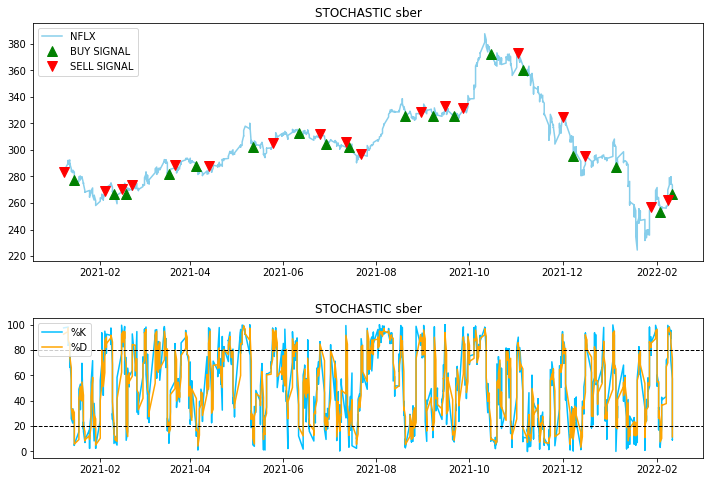

,close,%k,%d,stoch_signal,stoch_position
datetime,,,,,
2021-01-08,283.64,97.447119,92.487514,-1,0
2021-01-11,290.11,98.071217,94.616007,0,0
2021-01-11,292.10,96.250551,97.256296,0,0
2021-01-11,289.47,83.684951,92.668906,0,0
2021-01-11,289.49,83.778715,87.904739,0,0
...,...,...,...,...,...
2022-02-11,273.53,57.323601,73.311076,0,0
2022-02-11,267.76,20.935291,50.124004,0,0
2022-02-11,267.83,16.406701,31.555198,0,0


In [36]:
get_signals(prod_name, df)

## POSITION stoch+macd

In [20]:
# POSITION
def get_position(df, cci_signal):
    
    position = []
    for i in range(len(stoch_macd_signal)):
        if stoch_macd_signal[i] > 1:
            position.append(0)
        else:
            position.append(1)
            
    for i in range(len(df['close'])):
        if stoch_macd_signal[i] == 1:
            position[i] = 1
        elif stoch_macd_signal[i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
            
    close_price = df['close']
    k_line = df['%k']
    d_line = df['%d']
    macd_line = df['macd']
    signal_line = df['macd_signal']
    stoch_macd_signal = pd.DataFrame(stoch_macd_signal).rename(columns = {0:'stoch_macd_signal'}).set_index(df.index)
    position = pd.DataFrame(position).rename(columns = {0:'stoch_macd_position'}).set_index(df.index)
    
    frames = [close_price, k_line, d_line, macd_line, signal_line, stoch_macd_signal, position]
    strategy = pd.concat(frames, join = 'inner', axis = 1)
    
    return strategy

In [22]:
strategy.loc[lambda x: abs(x.stoch_macd_signal)==1]

,close,%k,%d,macd,macd_signal,stoch_macd_signal,stoch_macd_position
datetime,,,,,,,


## BACKTEST

In [14]:
# BACKTESTING

aapl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
adx_rsi_strategy_ret = []

for i in range(len(aapl_ret)):
    returns = aapl_ret['returns'][i]*strategy['stoch_macd_position'][i]
    adx_rsi_strategy_ret.append(returns)
    
adx_rsi_strategy_ret_df = pd.DataFrame(adx_rsi_strategy_ret).rename(columns = {0:'adx_rsi_returns'})
investment_value = 10000
number_of_stocks = investment_value/df['close'][0]
adx_rsi_investment_ret = []

for i in range(len(adx_rsi_strategy_ret_df['adx_rsi_returns'])):
    returns = number_of_stocks*adx_rsi_strategy_ret_df['adx_rsi_returns'][i]
    adx_rsi_investment_ret.append(returns)

adx_rsi_investment_ret_df = pd.DataFrame(adx_rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(adx_rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret/investment_value)*100
print('Profit gained from the STOCH + MACD strategy by investing 10k in AAPL : {}'.format(total_investment_ret))
print('Profit percentage of the STOCH + MACD strategy : {}%'.format(profit_percentage))

Profit gained from the STOCH + MACD strategy by investing 10k in AAPL : 1589.81
Profit percentage of the STOCH + MACD strategy : 15.898099999999998%


In [23]:
# сбер
strategy.adx_rsi_signal.value_counts()

 0    244
 1      2
-1      2
Name: adx_rsi_signal, dtype: int64

In [ ]:
# или

In [25]:
# BACKTESTING

aapl_ret = pd.DataFrame(np.diff(df['close'])).rename(columns = {0:'returns'})
adx_rsi_strategy_ret = []

for i in range(len(aapl_ret)):
    returns = aapl_ret['returns'][i]*strategy['stoch_macd_position'][i]
    adx_rsi_strategy_ret.append(returns)
    
adx_rsi_strategy_ret_df = pd.DataFrame(adx_rsi_strategy_ret).rename(columns = {0:'adx_rsi_returns'})
investment_value = 10000
number_of_stocks = investment_value/df['close'][0]
adx_rsi_investment_ret = []

for i in range(len(adx_rsi_strategy_ret_df['adx_rsi_returns'])):
    returns = number_of_stocks*adx_rsi_strategy_ret_df['adx_rsi_returns'][i]
    adx_rsi_investment_ret.append(returns)

adx_rsi_investment_ret_df = pd.DataFrame(adx_rsi_investment_ret).rename(columns = {0:'investment_returns'})
total_investment_ret = round(sum(adx_rsi_investment_ret_df['investment_returns']), 2)
profit_percentage = (total_investment_ret/investment_value)*100
print('Profit gained from the STOCH + MACD strategy by investing 10k in AAPL : {}'.format(total_investment_ret))
print('Profit percentage of the STOCH + MACD strategy : {}%'.format(profit_percentage))

Profit gained from the STOCH + MACD strategy by investing 10k in AAPL : 3148.07
Profit percentage of the STOCH + MACD strategy : 31.4807%


In [26]:
strategy.stoch_macd_signal.value_counts()

 0    204
 1     22
-1     21
Name: stoch_macd_signal, dtype: int64